# Financial Performance Analysis Project
*Role: Entry-Level Financial Data Analyst*  
*Company: SaaS Tech Inc. (fictional)*  

---

## 🎯 Project Objective
As a financial data analyst, I was tasked to automate the monthly **revenue & expense reporting pipeline**.  
Key goals:  
1. Pull and transform financial data from a relational database (SQLite).  
2. Calculate financial KPIs (Revenue, Expenses, Net Profit, Profit Margin %).  
3. Detect anomalies in margins.  
4. Forecast next quarter’s revenue and expenses.  
5. Deliver results in a format that executives can use.  

---

## 📂 Step 1. Load Dataset



In [1]:
import pandas as pd
import kagglehub
from pathlib import Path

# Download dataset
path = kagglehub.dataset_download("ziya07/accounting-data-for-financial-management")
print("Dataset Path:", path)

DATA_DIR = Path(path)
csv_path = next(DATA_DIR.rglob("*.csv"))
csv_path


Dataset Path: /kaggle/input/accounting-data-for-financial-management


PosixPath('/kaggle/input/accounting-data-for-financial-management/accounting_data.csv')

## 🔎 Step 2 — Read & Inspect
Standardize column names. Detect a date column and quickly view dtypes.


In [2]:
df = pd.read_csv(csv_path)

# tidy column names
df.columns = (df.columns.str.strip()
                        .str.lower()
                        .str.replace(r"[^a-z0-9_]+","_", regex=True))

# best-guess date column
date_col = None
for cand in ["date","transaction_date","period","month","quarter_end"]:
    if cand in df.columns:
        df[cand] = pd.to_datetime(df[cand], errors="coerce")
        date_col = cand
        break

print("Date column:", date_col)
print("Columns:", df.columns.tolist())
df.head(10)


Date column: date
Columns: ['transaction_id', 'date', 'account_type', 'transaction_amount', 'cash_flow', 'net_income', 'revenue', 'expenditure', 'profit_margin', 'debt_to_equity_ratio', 'operating_expenses', 'gross_profit', 'transaction_volume', 'processing_time_seconds_', 'accuracy_score', 'missing_data_indicator', 'normalized_transaction_amount', 'transaction_outcome']


,transaction_id,date,account_type,transaction_amount,cash_flow,net_income,revenue,expenditure,profit_margin,debt_to_equity_ratio,operating_expenses,gross_profit,transaction_volume,processing_time_seconds_,accuracy_score,missing_data_indicator,normalized_transaction_amount,transaction_outcome
0,1,2025-01-01,Asset,1176,3184,2174,3137,1823,0.607221,2.067004,4098,2327,8,1.894686,0.959936,False,0.218724,1
1,2,2025-01-02,Asset,1291,3221,3236,4694,2746,0.355608,2.347537,3872,388,5,1.728990,0.966382,False,0.242232,1
2,3,2025-01-03,Revenue,4966,3309,3689,3363,3102,0.678347,1.901003,4780,2616,2,1.707099,0.828307,False,0.993459,1
3,4,2025-01-04,Expense,4641,1952,245,4373,808,0.221047,0.934125,4948,2237,8,1.750641,0.984149,False,0.927024,1
4,5,2025-01-05,Expense,2305,2131,2037,4956,644,0.509323,1.061178,3289,1729,3,0.879708,0.929107,False,0.449509,1
5,6,2025-01-06,Revenue,3102,2795,1715,909,3287,0.438448,2.546492,3129,1770,2,1.294922,0.882669,False,0.612428,1
6,7,2025-01-07,Revenue,3847,2485,3955,4309,3011,0.771130,2.185805,3877,567,5,1.430321,0.802491,False,0.764718,1
7,8,2025-01-08,Asset,3061,4125,3477,612,3914,0.551012,1.090881,1875,3335,3,1.239121,0.828076,False,0.604047,1
8,9,2025-01-09,Expense,1490,2044,1907,3273,1045,0.412441,2.932288,4847,621,2,1.517137,0.808087,False,0.282911,1
9,10,2025-01-10,Liability,3265,3041,2905,898,3931,0.789666,2.788718,2001,2829,5,0.558296,0.865846,False,0.645748,1


## 🧹 Step 3 — Light Cleaning
Coerce numeric where possible (removes commas), keep only rows with a valid date.


In [3]:
# try to coerce numeric strings
for c in df.columns:
    if df[c].dtype == "object":
        try:
            df[c] = pd.to_numeric(df[c].str.replace(",","", regex=False), errors="ignore")
        except Exception:
            pass

# drop rows without a date (if any)
if date_col:
    df = df[df[date_col].notna()].copy()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   transaction_id                 1000 non-null   int64         
 1   date                           1000 non-null   datetime64[ns]
 2   account_type                   1000 non-null   object        
 3   transaction_amount             1000 non-null   int64         
 4   cash_flow                      1000 non-null   int64         
 5   net_income                     1000 non-null   int64         
 6   revenue                        1000 non-null   int64         
 7   expenditure                    1000 non-null   int64         
 8   profit_margin                  1000 non-null   float64       
 9   debt_to_equity_ratio           1000 non-null   float64       
 10  operating_expenses             1000 non-null   int64         
 11  gross_profit      

/tmp/ipykernel_13/2821003563.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c].str.replace(",","", regex=False), errors="ignore")


## 🗄️ Step 4 — Simulate a Relational DB (SQLite)
In real teams, data sits in RDBMS. We’ll write to SQLite and use SQL for rollups.


In [4]:
import sqlite3

conn = sqlite3.connect("finance.db")
df.to_sql("raw_financials", conn, if_exists="replace", index=False)

# sanity: list columns in the SQL table
pd.read_sql("PRAGMA table_info(raw_financials);", conn)


,cid,name,type,notnull,dflt_value,pk
0,0,transaction_id,INTEGER,0,None,0
1,1,date,TIMESTAMP,0,None,0
2,2,account_type,TEXT,0,None,0
3,3,transaction_amount,INTEGER,0,None,0
4,4,cash_flow,INTEGER,0,None,0
5,5,net_income,INTEGER,0,None,0
6,6,revenue,INTEGER,0,None,0
7,7,expenditure,INTEGER,0,None,0
8,8,profit_margin,REAL,0,None,0
9,9,debt_to_equity_ratio,REAL,0,None,0


## 🧮 Step 5 — Monthly Company Rollup (SQL)
**Fix we made:** this dataset has **`expenditure`** (not `expenses`) and **no `business_unit`**.  
We’ll aggregate to company totals by month.


In [5]:
# detect the expense column name
cols = pd.read_sql("PRAGMA table_info(raw_financials);", conn)["name"].tolist()
expense_col = "expenses" if "expenses" in cols else "expenditure"

q_company = f"""
SELECT
  DATE(strftime('%Y-%m-01', {date_col})) AS month,
  SUM(COALESCE(revenue, 0))      AS total_revenue,
  SUM(COALESCE({expense_col},0)) AS total_expense
FROM raw_financials
GROUP BY month
ORDER BY month;
"""
company = pd.read_sql(q_company, conn, parse_dates=["month"])
company.head()


,month,total_revenue,total_expense
0,2025-01-01,85103,58800
1,2025-02-01,82350,66486
2,2025-03-01,87633,60752
3,2025-04-01,87438,56546
4,2025-05-01,80445,46502


## 🔁 (Optional) Step 5B — Breakdown by Account Type
If you want a slice by `account_type` (e.g., Asset/Revenue/Expense), use this too.


In [6]:
q_by_type = f"""
SELECT
  DATE(strftime('%Y-%m-01', {date_col})) AS month,
  COALESCE(account_type, 'Unknown') AS account_type,
  SUM(COALESCE(revenue, 0))      AS total_revenue,
  SUM(COALESCE({expense_col},0)) AS total_expense
FROM raw_financials
GROUP BY month, account_type
ORDER BY month, account_type;
"""
monthly_by_type = pd.read_sql(q_by_type, conn, parse_dates=["month"])
monthly_by_type.head()


,month,account_type,total_revenue,total_expense
0,2025-01-01,Asset,13395,9846
1,2025-01-01,Expense,20948,8758
2,2025-01-01,Liability,17947,12551
3,2025-01-01,Revenue,32813,27645
4,2025-02-01,Asset,25010,13856


## 📊 Step 6 — KPIs & Anomaly Flags
Compute Net Income, Margin %, and flag months where margin < 5%.


In [7]:
import numpy as np

company["net_income"] = company["total_revenue"] - company["total_expense"]
company["margin_pct"] = (company["net_income"] / company["total_revenue"])\
    .replace([np.inf, -np.inf], 0) * 100
company["anomaly_flag"] = (company["margin_pct"] < 5).map({True:"Yes", False:"No"})
company.tail()


,month,total_revenue,total_expense,net_income,margin_pct,anomaly_flag
28,2027-05-01,73911,61869,12042,16.292568,No
29,2027-06-01,73866,63308,10558,14.293450,No
30,2027-07-01,80935,62620,18315,22.629270,No
31,2027-08-01,77610,62889,14721,18.967917,No
32,2027-09-01,68265,60049,8216,12.035450,No


## 📈 Step 7 — Visualize Trends
One chart per figure: Revenue vs Expense and Margin % over time.


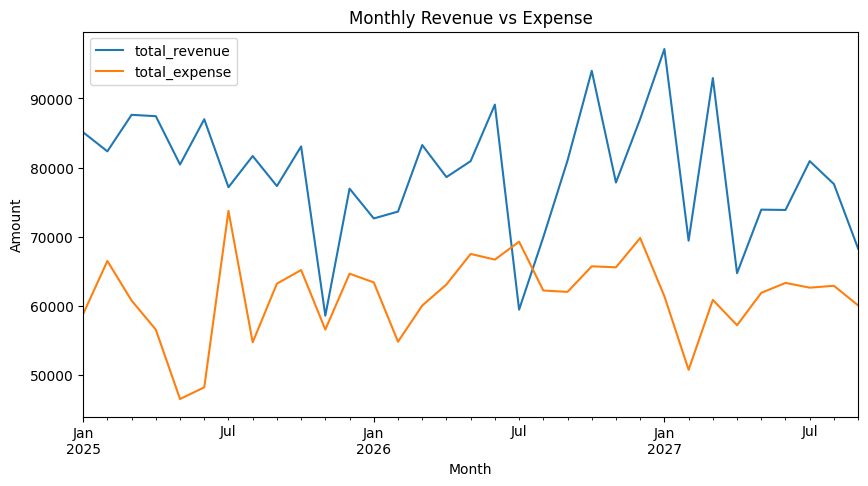

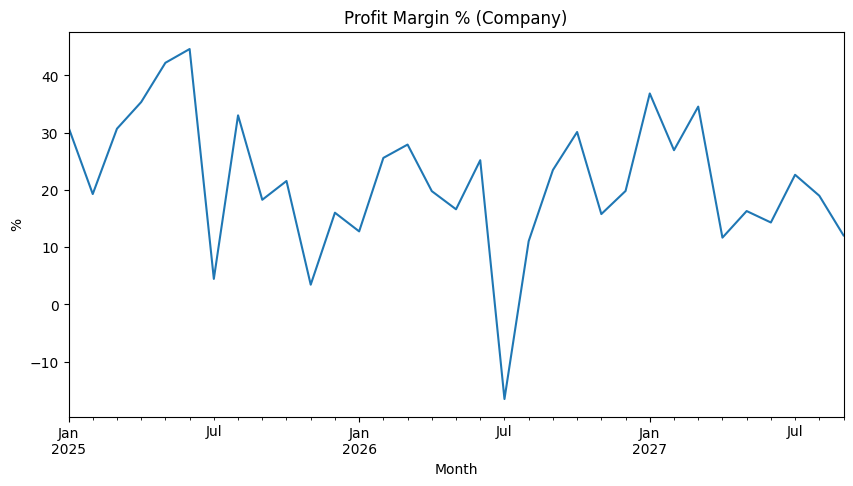

In [8]:
import matplotlib.pyplot as plt

company_plot = company.set_index("month")

company_plot[["total_revenue","total_expense"]].plot(figsize=(10,5))
plt.title("Monthly Revenue vs Expense")
plt.ylabel("Amount")
plt.xlabel("Month")
plt.show()

company_plot["margin_pct"].plot(figsize=(10,5))
plt.title("Profit Margin % (Company)")
plt.ylabel("%")
plt.xlabel("Month")
plt.show()


## 🔮 Step 8 — 3-Month Forecast (ETS/Holt-Winters)
**Fixes we made:**  
- Avoid multiplicative/Box-Cox to prevent convergence issues.  
- If you have < 24 months, skip seasonality.


In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

y = company.set_index("month")["total_revenue"].asfreq("MS").interpolate(limit_direction="both")
n = len(y)

seasonal = "add" if n >= 24 else None
model = ExponentialSmoothing(y, trend="add", seasonal=seasonal, seasonal_periods=(12 if seasonal else None))
fit = model.fit(optimized=True, use_brute=True, remove_bias=True)
forecast = fit.forecast(3)
forecast


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2027-10-01    77249.604300
2027-11-01    52648.270121
2027-12-01    70470.647107
Freq: MS, dtype: float64

## 🧾 Step 9 — Executive Summary (Numbers for your README)
Summarize growth, average margin, anomaly months, and forecast.


In [10]:
last_12 = company.tail(12)
rev_growth = float("nan")
if len(last_12) >= 2 and last_12["total_revenue"].iloc[0] != 0:
    rev_growth = (last_12["total_revenue"].iloc[-1] / last_12["total_revenue"].iloc[0] - 1) * 100

avg_margin = company["margin_pct"].tail(12).mean()
anomaly_months = company.loc[company["anomaly_flag"]=="Yes","month"].dt.strftime("%Y-%m").tolist()

summary = {
    "12m_revenue_growth_pct": None if pd.isna(rev_growth) else round(rev_growth, 1),
    "12m_avg_margin_pct": round(float(avg_margin), 1) if not pd.isna(avg_margin) else None,
    "anomaly_months": anomaly_months,
    "next_3mo_revenue_forecast": {k.strftime("%Y-%m"): float(v) for k,v in forecast.items()}
}
summary


{'12m_revenue_growth_pct': -27.4,
 '12m_avg_margin_pct': 21.7,
 'anomaly_months': ['2025-07', '2025-11', '2026-07'],
 'next_3mo_revenue_forecast': {'2027-10': 77249.60430016377,
  '2027-11': 52648.270121154776,
  '2027-12': 70470.64710743983}}

## 💾 Step 10 — Save Artifacts for Portfolio
Write figures & tables to `/kaggle/working`, then **Save Version** so they persist.


In [11]:
from pathlib import Path

FIG_DIR = Path("/kaggle/working/figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR = Path("/kaggle/working/outputs"); OUT_DIR.mkdir(exist_ok=True, parents=True)

# replot and save
company_plot = company.set_index("month")
ax = company_plot[["total_revenue","total_expense"]].plot(figsize=(10,5))
plt.title("Monthly Revenue vs Expense"); plt.ylabel("Amount"); plt.xlabel("Month")
fig1 = ax.get_figure(); fig1.savefig(FIG_DIR/"revenue_vs_expense.png", bbox_inches="tight")
plt.close(fig1)

ax = company_plot["margin_pct"].plot(figsize=(10,5))
plt.title("Profit Margin % (Company)"); plt.ylabel("%"); plt.xlabel("Month")
fig2 = ax.get_figure(); fig2.savefig(FIG_DIR/"profit_margin.png", bbox_inches="tight")
plt.close(fig2)

# outputs
company.to_csv(OUT_DIR/"monthly_company.csv", index=False)
pd.Series(forecast).to_csv(OUT_DIR/"forecast_next_3_months.csv", header=["forecast"])
pd.Series(summary, dtype="object").to_json(OUT_DIR/"executive_summary.json", indent=2)

FIG_DIR, OUT_DIR


(PosixPath('/kaggle/working/figures'), PosixPath('/kaggle/working/outputs'))

## 🧪 Step 11 — Repro Notes
Record tool versions for transparency.


In [12]:
import sys, numpy, matplotlib, statsmodels, pandas
versions = {
    "python": sys.version.split()[0],
    "pandas": pandas.__version__,
    "numpy": numpy.__version__,
    "matplotlib": matplotlib.__version__,
    "statsmodels": statsmodels.__version__
}
versions


{'python': '3.11.13',
 'pandas': '2.2.3',
 'numpy': '1.26.4',
 'matplotlib': '3.7.2',
 'statsmodels': '0.14.4'}